In [179]:
from __future__ import division

import numpy as np
import pandas as pd

from itertools import combinations

from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [154]:
churn_data = pd.read_csv('../../churn_analysis.csv', index_col=0)

In [158]:
сhurn_data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False


In [156]:
churn_data.churn = churn_data.churn.str.replace('.', '')

In [157]:
churn_data.describe()

,account_length,area_code,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.990999,0.484236
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.819138,0.138560
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.390000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,1.000000,0.480000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,2.000000,0.580000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,2.000000,0.960000


Рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора. 

Для этого мы воспользуемся критерием хи-квадрат.  Построим таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.  Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции 

In [16]:
control_group = сhurn_data[сhurn_data.treatment == 1]

In [55]:
control_group = pd.pivot_table(control_group, values='treatment', index='state', columns='churn', aggfunc=len, fill_value=0)

In [56]:
control_group.head()

churn,False,True
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [58]:
states_list = control_group.index.unique().tolist()

In [64]:
permutation_states = list(combinations(states_list, 2))
assert len(permutation_states) == 1275

In [71]:
chi2_val = pd.DataFrame(columns=['state1', 'state2', 'chi2_stat', 'p_value'])

for idx, (st1, st2) in enumerate(permutation_states):
    matrix_conf = control_group.loc[[st1, st2], :]
    chi2_val.loc[idx, 'state1'] = st1
    chi2_val.loc[idx, 'state2'] = st2
    chi2, p_value = stats.chi2_contingency(matrix_conf.values, correction=False)[:2]
    chi2_val.loc[idx, 'chi2_stat'] = chi2
    chi2_val.loc[idx, 'p_value'] = p_value

In [192]:
matrix_conf

churn,False,True
state,,
WV,27,5
WY,20,2


In [72]:
chi2_val

,state1,state2,chi2_stat,p_value
0,AK,AL,1.54672,0.213621
1,AK,AR,4.41,0.0357288
2,AK,AZ,0.419079,0.517397
3,AK,CA,4.84435,0.0277369
4,AK,CO,2.68864,0.101066
...,...,...,...,...
1270,WA,WV,1.72063,0.189612
1271,WA,WY,3.20158,0.0735671
1272,WI,WV,0.666667,0.414216
1273,WI,WY,0.00829726,0.927422


In [76]:
chi2_val.p_value[chi2_val['p_value'] < 0.05].count()

34

Интерпретация числа достигаемых уровней значимости,  меньших $\alpha=0.05$, некорректна,  поскольку не сделана поправка на множественную проверку гипотез.

Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты. 


В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в  таблице сопряженности  может быть аппроксимировано с помощью непрерывного распределения xи-квадрат.  Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного  $O_i$ и ожидаемого $E_i$ значений, то есть, статистика с такой поправкой выглядит так: 
$$\chi _{\text{Yates}}^{2}=\sum _{i=1}^{N}{(|O_{i}-E_{i}|-0.5)^{2} \over E_{i}}$$.


Такая поправка, как несложно догадаться по формуле, как правило, уменьшает  значение статистики  $\chi^{2}$, то есть увеличивает достигаемый уровень значимости.  
Эта поправка обычно используется для таблиц сопряженности размером 2x2  и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).  
Полезно знать, что эта поправка часто включена по  умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.   
Снова проведём сравнения, только теперь с включенной коррекцией 

In [87]:
for idx, (st1, st2) in enumerate(permutation_states):
    matrix_conf = control_group.loc[[st1, st2], :]
    chi2_val.loc[idx, 'state1'] = st1
    chi2_val.loc[idx, 'state2'] = st2
    chi2, p_value = stats.chi2_contingency(matrix_conf.values, correction=True)[:2]
    chi2_val.loc[idx, 'chi2_stat_corr'] = chi2
    chi2_val.loc[idx, 'p_value_corr'] = p_value

In [191]:
(chi2_val['p_value_corr'] < 0.05).sum()

0

In [189]:
chi2_val['p_value_corr'].mean() > chi2_val['p_value'].mean()

True

Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений  достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.

Достигаемые уровни значимости на наших данных,  полученные с помощью критерия xи-квадрат с поправкой Йетса,  в среднем получаются больше, чем соответствующие значения  без поправки.

Что если у нас мало данных,  мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку,  предположения  критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот  критерий не использует приближений  и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

In [195]:
tabledata = [["a", "b", "a+b"],
         ["c", "d", "c+d"],
         ["a+c", "b+d", "n=a+b+c+d"]]

pd.DataFrame(tabledata, columns=["Группа 1","Группа 2", "Σ"], index=["Воздействие 1", "Воздействие 2", "Σ"])

,Группа 1,Группа 2,Σ
Воздействие 1,a,b,a+b
Воздействие 2,c,d,c+d
Σ,a+c,b+d,n=a+b+c+d


Тогда вероятность получить именно такие a, b, c, da,b,c,d при фиксированных значениях сумм по строкам и по столбцам) задается выражением

$$p={\frac {\displaystyle {{a+b} \choose {a}}\displaystyle {{c+d} \choose {c}}}{\displaystyle {{n} \choose {a+c}}}}={ \dfrac {(a+b)!~(c+d)!~(a+c)!~(b+d)!}{a!~~b!~~c!~~d!~~n!}}$$

В числителе этой дроби стоит суммарное количество способов выбрать aa и cc из a +b a+b и c + dc+d соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца a + ca+c из общего количества рассматриваемых объектов nn.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения a, b, c, d a,b,c,d, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора a, b, c, d a,b,c,d нужно вычислить значение $p_i$ по формуле выше и просуммировать все такие значения  $p_i$, которые меньше или равны  pp, которое мы вычислили по наблюдаемым значениям a, b, c, d a,b,c,d.  
Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы n×m.

Посчитаем для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами

In [91]:
for idx, (st1, st2) in enumerate(permutation_states):
    matrix_conf = control_group.loc[[st1, st2], :]
    chi2_val.loc[idx, 'state1'] = st1
    chi2_val.loc[idx, 'state2'] = st2
    chi2, p_value = stats.fisher_exact(matrix_conf.values)[:2]
    chi2_val.loc[idx, 'F_ex_stat'] = chi2
    chi2_val.loc[idx, 'p_value_F'] = p_value

In [92]:
chi2_val

,state1,state2,chi2_stat,p_value,chi2_stat_corr,p_value_corr,F_ex_stat,p_value_F
0,AK,AL,1.54672,0.213621,0.639205,0.423999,3.800000,0.381063
1,AK,AR,4.41,0.0357288,2.722500,0.098943,8.636364,0.068862
2,AK,AZ,0.419079,0.517397,0.002138,0.963119,2.235294,0.604990
3,AK,CA,4.84435,0.0277369,3.054957,0.080491,9.500000,0.063965
4,AK,CO,2.68864,0.101066,1.435795,0.230821,5.588235,0.187034
...,...,...,...,...,...,...,...,...
1270,WA,WV,1.72063,0.189612,0.961945,0.326697,0.423280,0.207829
1271,WA,WY,3.20158,0.0735671,2.006546,0.156622,0.228571,0.134552
1272,WI,WV,0.666667,0.414216,0.166667,0.683091,2.037037,0.686168
1273,WI,WY,0.00829726,0.927422,0.187207,0.665252,1.100000,1.000000


In [98]:
p_v, p_v_corr, p_v_F = chi2_val['p_value'], chi2_val['p_value_corr'], chi2_val['p_value_F']
p_v_corr.mean() > p_v_F.mean()

True

In [101]:
p_v.mean() < p_v_F.mean()

True

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса


Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.


Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки


Попробуем применить полученные знания о разных видах корреляции и ее применимости на практике. 

Рассмотрим пару признаков day_calls и  mes_estim. Посчитаем корреляцию Пирсона между этими признаками на всех данных, ее значимость. 

In [120]:
correlations = pd.DataFrame(columns=['day_calls', 'mes_estim'])
correlations['day_calls'] = churn_data.day_calls
correlations['mes_estim'] = churn_data.mes_estim

In [124]:
correlations.corr(method='pearson')

,day_calls,mes_estim
day_calls,1.000000,-0.051794
mes_estim,-0.051794,1.000000


In [129]:
corr, p_value = stats.pearsonr(correlations.day_calls, correlations.mes_estim)
print(f"correlation pearson: {corr}; p-value: {p_value}")

correlation pearson: -0.05179435058757252; p-value: 0.0027798836869732313


Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. 



Еще раз рассмотрим пару признаков day_calls и  mes_estim. Посчитаем корреляцию Спирмена между этими признаками на всех данных, ее значимость

In [131]:
corr, p_value = stats.spearmanr(correlations)
print(f"correlation spearmanr: {corr}; p-value: {p_value}")

correlation spearmanr: 0.043349880533927444; p-value: 0.012317367189170543


Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам.

((array([-3.5297919 , -3.28786833, -3.15418238, ...,  3.15418238,
          3.28786833,  3.5297919 ]),
  array([0.05, 0.05, 0.05, ..., 0.89, 0.91, 0.96])),
 (0.13861708020693375, 0.4842364236423642, 0.9996050483985329))

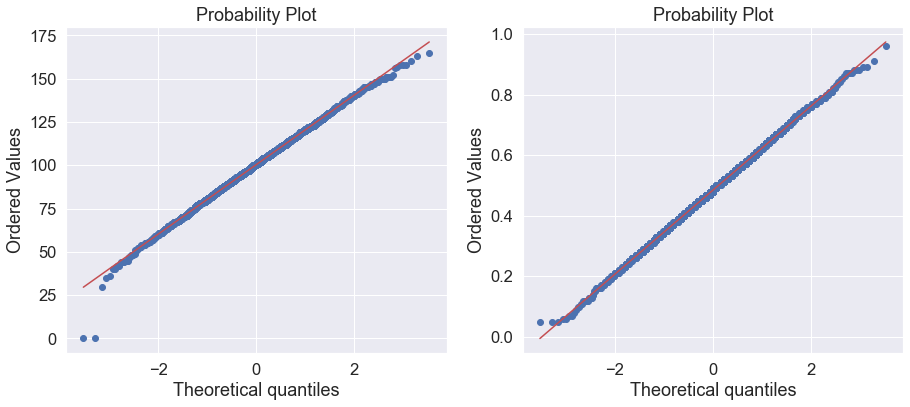

In [134]:
plt.figure(figsize=(15,6))
plt.subplot(121)
stats.probplot(churn_data.day_calls, dist="norm", plot=plt)
plt.subplot(122)
stats.probplot(churn_data.mes_estim, dist="norm", plot=plt)

Text(0, 0.5, 'mes_estim')

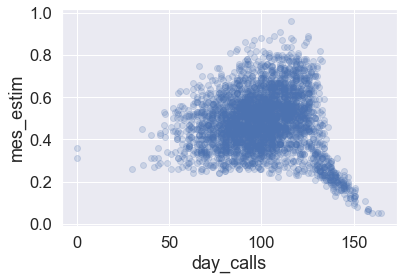

In [135]:
plt.scatter(churn_data.day_calls, churn_data.mes_estim, alpha=0.2)
plt.xlabel('day_calls')
plt.ylabel('mes_estim')

Посчитаем значение коэффицента корреляции Крамера между двумя признаками:  штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1).

$$\phi_c(X^n_1, X^n_2)=\sqrt{ \frac{\chi^2(X^n_1, X^n_2)}{n(min(K_1, K_2) - 1)}}$$

In [136]:
control_group.head()

churn,False,True
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [137]:
def cramers_stat(confusion_matrix):
    chi2, p_value = stats.chi2_contingency(confusion_matrix)[:2]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1))), p_value

In [140]:
print('V Cramer stat value: %.4f, p-value: %.10f' % cramers_stat(control_group.values))

V Cramer stat value: 0.2004, p-value: 0.7097590043


Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным. 

In [161]:
data_states = pd.pivot_table(churn_data, values='account_length', index='state', columns=['treatment', 'churn'],
                               aggfunc=len, fill_value=0)
data_states.head()

treatment     0          1          2     
churn     False True False True False True
state                                     
AK           15    2    19    1    15    0
AL           22    1    25    5    25    2
AR           14    3    11    5    19    3
AZ           26    0    17    2    17    2
CA           10    3    10    5     5    1

In [163]:
props_churn = np.array([data_states.loc[:, treat].loc[:, 'True'].sum() / 
                        (data_states.loc[:, treat].loc[:, 'False'].sum() + data_states.loc[:, treat].loc[:, 'True'].sum())
                        for treat in range(3)])
for i, prop in enumerate(props_churn):
    print('Treatment #%d prop. of churn = 1: %.4f' % (i, prop))

Treatment #0 prop. of churn = 1: 0.1456
Treatment #1 prop. of churn = 1: 0.1641
Treatment #2 prop. of churn = 1: 0.1251


In [166]:
wilson_ints = np.array([proportion_confint(data_states.loc[:, treat].loc[:, 'True'].sum(),
                                           (data_states.loc[:, treat].loc[:, 'False'].sum() + data_states.loc[:, treat].loc[:, 'True'].sum()),
                                           method='wilson') for treat in range(3)])
for i, wils in enumerate(wilson_ints):
    print('Treatment #%d prop. of churn = 1: %s' % (i, str(wils)))

Treatment #0 prop. of churn = 1: [0.12628913 0.16736788]
Treatment #1 prop. of churn = 1: [0.14334707 0.18716506]
Treatment #2 prop. of churn = 1: [0.1068801  0.14594876]


In [174]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    l1 = sample1.loc[:, 'False'].sum() + sample1.loc[:, 'True'].sum()
    l2 = sample2.loc[:, 'False'].sum() + sample2.loc[:, 'True'].sum()
    p1 = sample1.loc[:, 'True'].sum() / l1
    p2 = sample2.loc[:, 'True'].sum() / l2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    
    return (left_boundary, right_boundary)

In [175]:
def proportions_diff_z_stat_ind(sample1, sample2):
    l1 = sample1.loc[:, 'False'].sum() + sample1.loc[:, 'True'].sum()
    l2 = sample2.loc[:, 'False'].sum() + sample2.loc[:, 'True'].sum()
    p1 = sample1.loc[:, 'True'].sum() / l1
    p2 = sample2.loc[:, 'True'].sum() / l2
    P = (p1*l1 + p2*l2) / (l1 + l2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / l1 + 1. / l2))

In [176]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [177]:
p_val_table = np.empty((3, 3))
i = 0
for tr1, tr2 in combinations(range(3), 2):
    print('Treatments #%d and %d: ' % (tr1, tr2)),
    confint_diff = proportions_confint_diff_ind(data_states.loc[:, tr1], data_states.loc[:, tr2])
    print('[%.4f, %.4f], ' % confint_diff),
    p_val = proportions_diff_z_test(proportions_diff_z_stat_ind(data_states.loc[:, tr1], data_states.loc[:, tr2]))
    p_val_table[i, :] = tr1, tr2, p_val
    i += 1
    print('p-value: %.4f' % p_val)
p_val_table

Treatments #0 and 1: 
[-0.0485, 0.0116], 
p-value: 0.2283
Treatments #0 and 2: 
[-0.0078, 0.0489], 
p-value: 0.1564
Treatments #1 and 2: 
[0.0096, 0.0683], 
p-value: 0.0093


array([[0.        , 1.        , 0.22833116],
       [0.        , 2.        , 0.15642469],
       [1.        , 2.        , 0.00934808]])

In [173]:
data_states

treatment     0          1          2     
churn     False True False True False True
state                                     
AK           15    2    19    1    15    0
AL           22    1    25    5    25    2
AR           14    3    11    5    19    3
AZ           26    0    17    2    17    2
CA           10    3    10    5     5    1
CO           20    2    17    5    20    2
CT           22    3    25    5    15    4
DC           19    3    18    1    12    1
DE           18    4    16    1    18    4
FL           16    4    18    2    21    2
GA           11    5    19    2    16    1
HI           17    1    12    1    21    1
IA           13    1    13    2    15    0
ID           22    6    16    2    26    1
IL           25    2    11    1    17    2
IN           22    4    20    3    20    2
KS           21    2    18    7    18    4
KY           18    2    21    4    12    2
LA           11    1    15    0    21    3
MA           20    2    17    7    17    2
MD           11    6    19    5    23    6
ME           14    4    20    8    15    1
MI           22    6    17    5    18    5
MN           28    6    19    2    22    7
MO           22    1    17    4    17    2
MS           15    9    20    4    16    1
MT           19    6    22    4    13    4
NC           21    4    16    3    20    4
ND           17    2    21    3    18    1
NE           16    1    21    3    19    1
NH           20    3    10    2    17    4
NJ           12    7    20    4    18    7
NM           14    3    27    2    15    1
NV           11    3    18    6    23    5
NY           22    4    27    6    19    5
OH           25    3    22    2    21    5
OK           19    1    11    2    22    6
OR           18    7    18    3    31    1
PA           13    3    14    4    10    1
RI           15    1    18    4    26    1
SC           15    3    16    5    15    6
SD           19    2    20    3    13    3
TN           18    1    11    1    19    3
TX           26    7    14    6    14    5
UT           23    4    18    4    21    2
VA           22    2    20    3    30    0
VT           24    1    18    5    23    2
WA           20    4    16    7    16    3
WI           25    4    22    2    24    1
WV           37    2    27    5    32    3
WY           23    4    20    2    25    3

In [180]:
_, p_corrected, _, _ = multipletests(p_val_table[:,2], alpha = 0.05, method = 'fdr_bh') 
p_corrected

array([0.22833116, 0.22833116, 0.02804425])